# Task 3: Customer Segmentation / Clustering
Perform customer segmentation using clustering techniques. Use both profile information
(from Customers.csv) and transaction information (from Transactions.csv).  
● You have the flexibility to choose any clustering algorithm and any number of clusters in
between(2 and 10)  
● Calculate clustering metrics, including the DB Index(Evaluation will be done on this).  
● Visualise your clusters using relevant plots.

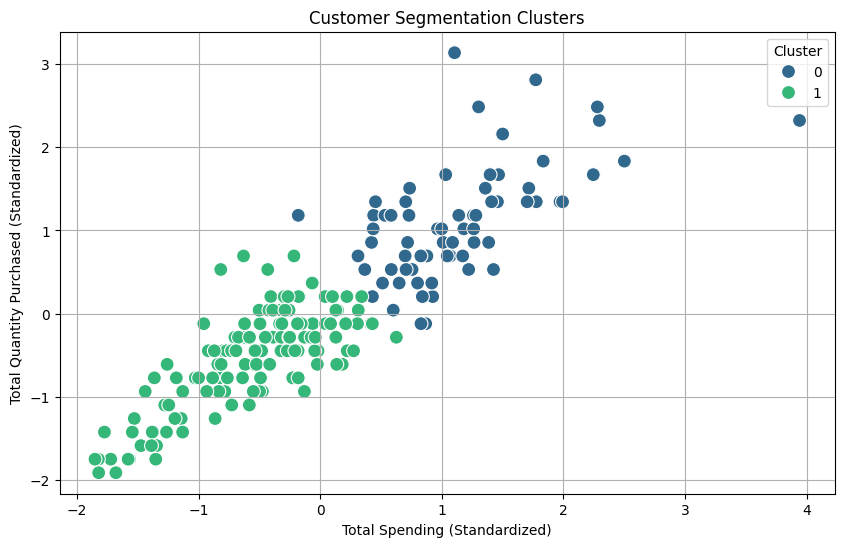

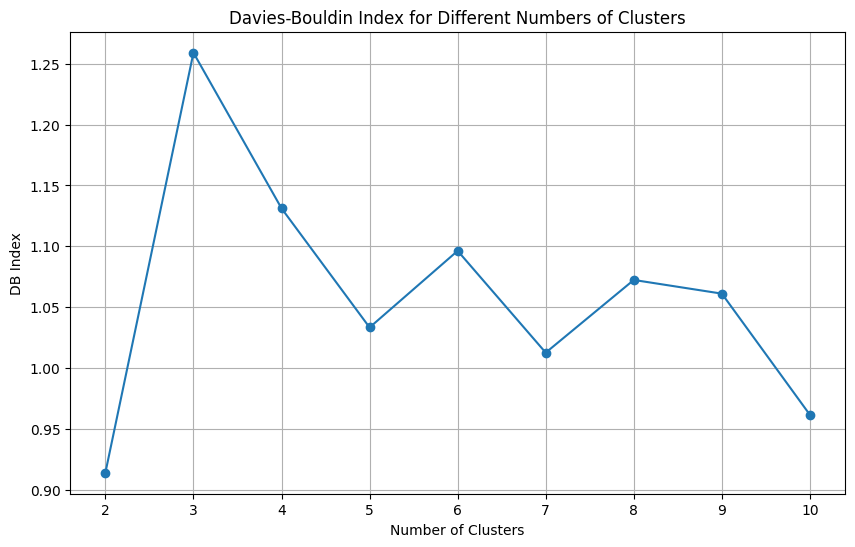

Optimal number of clusters: 2
Davies-Bouldin Index for optimal clusters: 0.9141427115577082


In [2]:
# Customer Segmentation and Clustering for eCommerce Dataset

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
transactions_path = "/content/Transactions.csv"
customers_path = "/content/Customers.csv"

transactions = pd.read_csv(transactions_path)
customers = pd.read_csv(customers_path)

# Merge datasets for analysis
merged_data = transactions.merge(customers, on="CustomerID", how="left")

# Feature engineering
# Aggregating transaction data for each customer
customer_profiles = merged_data.groupby("CustomerID").agg(
    {
        "TotalValue": "sum",  # Total spending
        "Quantity": "sum",    # Total quantity purchased
    }
).reset_index()

# Merge with customer profile information
customer_profiles = customer_profiles.merge(customers, on="CustomerID", how="left")

# Encoding categorical data
customer_profiles = pd.get_dummies(customer_profiles, columns=["Region"], drop_first=True)

# Standardize numerical features
scaler = StandardScaler()
numerical_features = ["TotalValue", "Quantity"]
customer_profiles[numerical_features] = scaler.fit_transform(customer_profiles[numerical_features])

# Clustering using KMeans
# Define the range of clusters to try
range_n_clusters = range(2, 11)

# Initialize variables to store results
db_scores = []
cluster_results = {}

for n_clusters in range_n_clusters:
    # Initialize and fit KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(customer_profiles.drop(["CustomerID", "CustomerName", "SignupDate"], axis=1))

    # Calculate Davies-Bouldin Index
    db_index = davies_bouldin_score(customer_profiles.drop(["CustomerID", "CustomerName", "SignupDate"], axis=1), labels)
    db_scores.append(db_index)

    # Store results
    cluster_results[n_clusters] = {
        "labels": labels,
        "centers": kmeans.cluster_centers_,
        "db_index": db_index
    }

# Find the optimal number of clusters (lowest DB Index)
optimal_clusters = min(cluster_results, key=lambda x: cluster_results[x]["db_index"])
optimal_labels = cluster_results[optimal_clusters]["labels"]
optimal_centers = cluster_results[optimal_clusters]["centers"]
optimal_db_index = cluster_results[optimal_clusters]["db_index"]

# Add cluster labels to the customer_profiles DataFrame
customer_profiles["Cluster"] = optimal_labels

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=customer_profiles["TotalValue"],
    y=customer_profiles["Quantity"],
    hue=customer_profiles["Cluster"],
    palette="viridis",
    s=100
)
plt.title("Customer Segmentation Clusters")
plt.xlabel("Total Spending (Standardized)")
plt.ylabel("Total Quantity Purchased (Standardized)")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

# Plot Davies-Bouldin Index for each number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, db_scores, marker="o")
plt.title("Davies-Bouldin Index for Different Numbers of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("DB Index")
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()

# Save results
customer_profiles.to_csv("Customer_Segmentation.csv", index=False)

print(f"Optimal number of clusters: {optimal_clusters}")
print(f"Davies-Bouldin Index for optimal clusters: {optimal_db_index}")
